# Dimensional Reduction and Clustering

In this notebook, we will explore how to use dimensional reduction and clustering techniques to analyze text data.

We will use the 20 Newsgroups dataset, which contains approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups (topics).

<img src="https://github.com/annekroon/gesis-machine-learning/blob/main/pictures/lego_stack/01_preprocessing.png?raw=1" alt="Preprocessing diagram" style="max-width: 150px;">
<img src="https://github.com/annekroon/gesis-machine-learning/blob/main/pictures/lego_stack/04_dimred_cluster.png?raw=1" alt="Dimensionality Reduction and Clustering diagram" style="max-width: 150px;">

We will perform `PCA` and `SVD` for dimensionality reduction, and `K-means` clustering for clustering.

## 0. Setup

In [38]:
# Python
# Standard library
import json
import re

# Numerical + plotting
import numpy as np
import matplotlib.pyplot as plt

# NLP / text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature extraction / pipelines / decomposition / clustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

#for the fetch_20newsgroups dataset:
from sklearn.datasets import fetch_20newsgroups

### define some functions to visualize results:

In [39]:
def plot_dimensionality_reduction(X_reduced, model):

    #determine the method name based on the model class
    if isinstance(model, TruncatedSVD):
        method_name = 'SVD'
    elif isinstance(model, PCA):
        method_name = 'PCA'
    else:
        method_name = type(model).__name__  #dallback to the class name if unknown

    #get the explained variance ratio (need for plots)
    explained_variance_ratio = model.explained_variance_ratio_

    #create a figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # 1. 3D scatter plot of first three components
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c='b', alpha=0.5)
    ax1.set_xlabel(f'{method_name}1')
    ax1.set_ylabel(f'{method_name}2')
    ax1.set_zlabel(f'{method_name}3')
    ax1.set_title(f'First Three {method_name} Components')

    # 2. Explained variance ratio
    ax2 = fig.add_subplot(222)
    ax2.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    ax2.set_xlabel(f'{method_name} Component')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title(f'Explained Variance Ratio by {method_name} Component')

    # 3. Cumulative explained variance ratio
    ax3 = fig.add_subplot(223)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    ax3.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    ax3.set_xlabel('Number of Components')
    ax3.set_ylabel('Cumulative Explained Variance Ratio')
    ax3.set_title('Cumulative Explained Variance Ratio')

    # 4. Scatter plot of first two components
    ax4 = fig.add_subplot(224)
    ax4.scatter(X_reduced[:, 0], X_reduced[:, 1], c='r', alpha=0.5)
    ax4.set_xlabel(f'{method_name}1')
    ax4.set_ylabel(f'{method_name}2')
    ax4.set_title(f'First Two {method_name} Components')

    plt.tight_layout()
    plt.show()

def print_top_terms(model, vectorizer, top_n_dim = 10, n_top_terms=10):
    """
    Print top terms associated with each component.
    The method name is automatically determined from the model object.

    Args:
    model: Fitted SVD or PCA object
    vectorizer: Fitted TF-IDF vectorizer
    n_top_terms (int): Number of top terms to print for each component
    """
    # Determine the method name based on the model class
    if isinstance(model, TruncatedSVD):
        method_name = 'SVD'
    elif isinstance(model, PCA):
        method_name = 'PCA'
    else:
        method_name = type(model).__name__  # Fallback to the class name if unknown

    feature_names = vectorizer.get_feature_names_out()
    for i, comp in enumerate(model.components_[:top_n_dim]):
        top_terms = [feature_names[idx] for idx in comp.argsort()[:-n_top_terms - 1:-1]]
        print(f"{method_name} Component {i + 1}: {', '.join(top_terms)}")

def visualize_clusters(features, cluster_labels, k):

    # Reduce the feature space to 2D for visualization
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features.toarray())

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1],
                          c=cluster_labels, cmap='viridis')

    # Add labels and title
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('K-means Clustering Results')

    # Add a color bar
    plt.colorbar(scatter, label='Cluster')

    # Add cluster centers
    centers = kmeans.cluster_centers_
    reduced_centers = pca.transform(centers)
    plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1],
                marker='x', s=200, linewidths=3, color='r', label='Cluster Centers')

    plt.legend()
    plt.show()

## 1. Preprocessing  
<img src="https://github.com/annekroon/gesis-machine-learning/blob/main/pictures/lego_stack/01_preprocessing.png?raw=1" alt="Preprocessing diagram" style="max-width: 150px;">

In this step, we will load in the data, explore it, and clean it up a bit.

We're working with the fetch_20newsgroups dataset from sklearn, which contains around 18,000 newsgroup posts on 20 topics.

In [52]:
#load the 20 newsgroups dataset:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
docs = newsgroups.data

#drop any empty documents:
docs = [doc for doc in docs if len(doc.strip()) > 0]

#let's check the number of documents:
print (f"Number of documents: {len(docs)}")

print("First document:")
print(docs[0])

Number of documents: 18331
First document:


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [53]:
#because this is quite a large dataset, let's take a random sample of 500 documents:
import random
random.seed(42)  # For reproducibility
docs = random.sample(docs, 1000)

In [66]:
def preprocess_text(docs, custom_stopwords=None):
    #NOTE: better lemmatizer that uses the WordNet lexical database.
    #NOTE: you can even pass it POS tags to improve the lemmatization (not done here).
    lemmatizer = WordNetLemmatizer()
    #get the default stopwords from NLTK (en).
    stop_words = set(stopwords.words('english'))

    #add custom stopwords if provided
    if custom_stopwords:
        stop_words.update(custom_stopwords)

    #instantiate an empty list for processed docs
    processed_docs = []

    #interate over the docs
    for text in docs:
        try:
            #lowercase
            text = text.lower()

            #tokenize with NLTK tokenizer
            tokens = nltk.word_tokenize(text)

            #remove non-alphabetic characters from tokens
            tokens = [re.sub(r'[^a-z\s]', '', token) for token in tokens]

            #combined stopwords removal and lemmatization
            tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

            #join tokens back to string=
            processed_text = ' '.join(tokens)

            #remove any double spaces that remain:
            processed_text = re.sub(r'\s+', ' ', processed_text).strip()

            #append processed text to output list:
            processed_docs.append(processed_text)

        except Exception as e: #raise error if smth goes wrong:
            print(f"Error processing text: {text}. Error: {e}")
            processed_docs.append("")

    return processed_docs

In [55]:
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
#execute preprocessing:
texts = preprocess_text(docs)

In [57]:
texts[0] #inspect first processed text

'graeme yes known bresenhams run length slice algorithm graeme incremental line see fundamental algorithm computer graphic graeme springerverlag berlin heidelberg graeme hmm nt think help might graeme take look following graeme doublestep incremental generation line circle graeme x wu j g rokne computer graphic image processing graeme vol mar pp graeme doublestep generation ellipsis x wu j g rokne graeme ieee computer graphic application may pp another paper might want consider article fungdraw title runlength slice line drawing algorithm without division operation author khun yee fung tina nicholl k dewdney journal computer graphic forum year volume number page c c khun yee'

# 3. Dimensionality Reduction and Clustering
<img src="https://github.com/annekroon/gesis-machine-learning/blob/main/pictures/lego_stack/04_dimred_cluster.png?raw=1" alt="Dimensionality Reduction and Clustering diagram" style="max-width: 150px;">


### Let's try applying `PCA` or `SVD`:

#### PCA:

Original number of features: 15252
Reduced number of features: 10
Reduced data shape: (1000, 10)


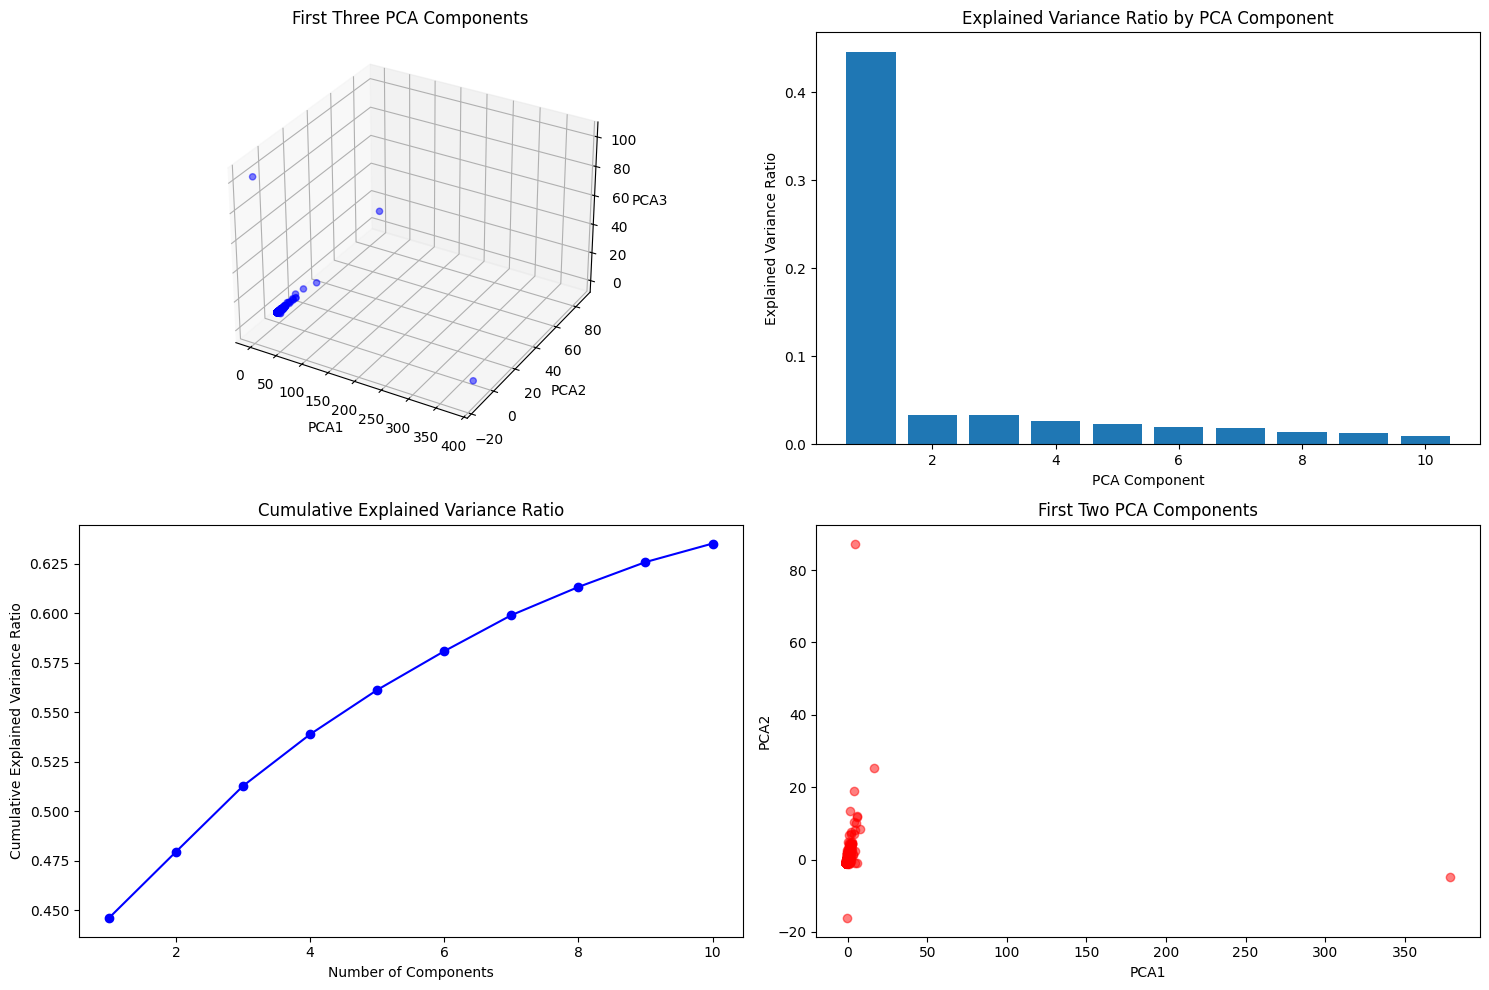

PCA Component 1: jpeg, image, file, gif, format, color, version, nt, program, quality
PCA Component 2: ra, god, jesus, nt, one, child, bible, christ, ye, john
PCA Component 3: den, pz, py, px, radius, double, rtheta, theta, sqrt, ra
PCA Component 4: ra, god, jesus, jpeg, bible, christ, ye, child, father, image
PCA Component 5: king, flame, ra, la, game, puck, went, cal, period, shot
PCA Component 6: gun, risk, death, nejm, study, suicide, homicide, home, time, stat
PCA Component 7: conference, nok, th, please, sa, may, hotel, registration, tromsoe, gun
PCA Component 8: vote, voting, yes, john, ballot, unmoderated, name, first, david, compososprogrammermisc
PCA Component 9: nt, chromium, people, would, think, know, want, could, one, believe
PCA Component 10: wsh, nyr, chi, mtl, edm, bos, tor, nyi, det, min


In [68]:
# Initialize a vectorizer:
my_vect = CountVectorizer()

# Initialize PCA object:
my_pca = PCA(n_components=10, random_state=42)

# Create a pipeline that vectorizes -> transforms to dense and -> runs PCA:
# NOTE: pipelines are a good way to combine multiple transformation steps into one object.
mypipe = make_pipeline(
    my_vect,
    FunctionTransformer(lambda x: np.asarray(x.todense()), accept_sparse=True),
    my_pca
)

#run the pipeline on the processed texts:
X_pca = mypipe.fit_transform(texts)

#print the number of dimensions in the DTM:
print(f"Original number of features: {len(my_vect.get_feature_names_out())}")
print(f"Reduced number of features: {X_pca.shape[1]}")
print(f"Reduced data shape: {X_pca.shape}")

#print plots of PCA results:
plot_dimensionality_reduction(X_pca, my_pca)

#report top terms for each PC:
print_top_terms(my_pca, my_vect)

#### SVD:

Original number of features: 15252
Reduced number of features: 1000
Reduced data shape: (1000, 1000)


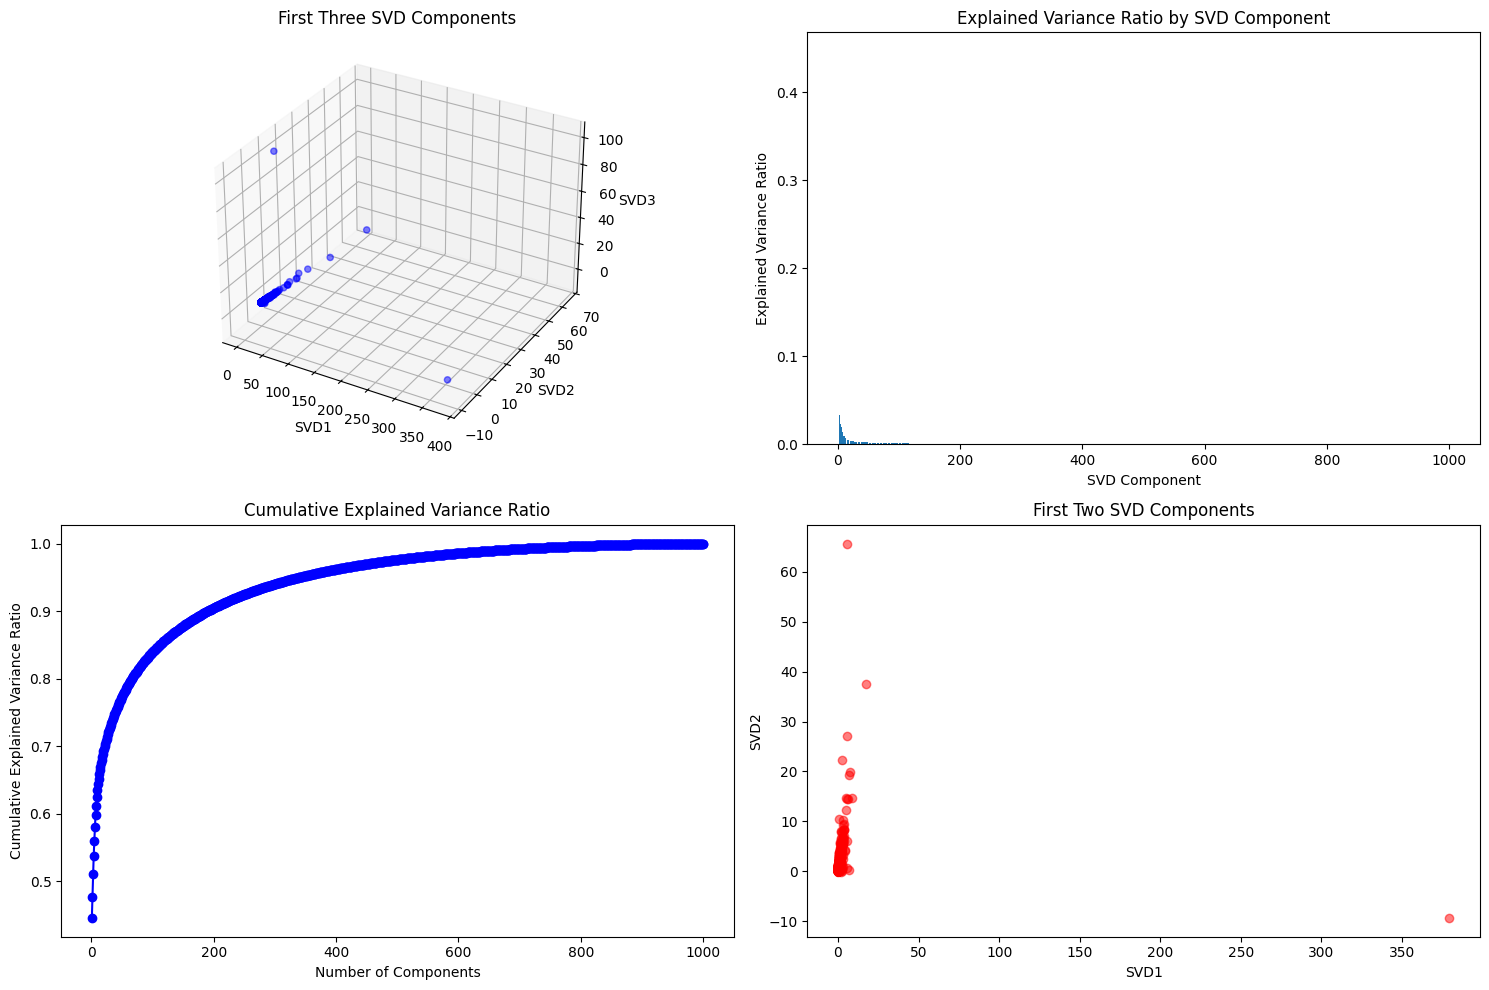

SVD Component 1: jpeg, image, file, gif, format, color, version, nt, program, quality
SVD Component 2: ra, nt, god, one, jesus, would, people, time, child, thing
SVD Component 3: den, py, px, pz, radius, double, rtheta, theta, sqrt, ntheta
SVD Component 4: ra, god, jesus, bible, christ, ye, child, father, john, jpeg
SVD Component 5: king, flame, la, game, puck, went, ra, cal, period, shot
SVD Component 6: gun, risk, death, nejm, study, suicide, homicide, home, time, stat
SVD Component 7: conference, nok, th, please, may, sa, hotel, registration, tromsoe, fare
SVD Component 8: vote, voting, yes, john, ballot, name, unmoderated, first, compososprogrammermisc, david
SVD Component 9: nt, would, people, chromium, think, know, vote, yes, could, voting
SVD Component 10: wsh, nyr, chi, edm, mtl, bos, nyi, det, tor, min


In [65]:
#initialize a vectorizer:
my_vect = CountVectorizer()

#initialize TruncatedSVD object:
my_svd = TruncatedSVD(n_components=1000)

# Create a pipeline that vectorizes -> runs SVD -> normalizes the results:
mypipe = make_pipeline(
    my_vect,
    my_svd,
)

#run the pipeline on the processed texts:
X_svd = mypipe.fit_transform(texts)

#print the number of dimensions in the DTM and reduced data:
print(f"Original number of features: {len(my_vect.get_feature_names_out())}")
print(f"Reduced number of features: {X_svd.shape[1]}")
print(f"Reduced data shape: {X_svd.shape}")

#get plots of SVD results:
plot_dimensionality_reduction(X_svd, my_svd)

# Report top terms for each SVD component:
print_top_terms(my_svd, my_vect)

### Let's try applying `K-means` clustering:

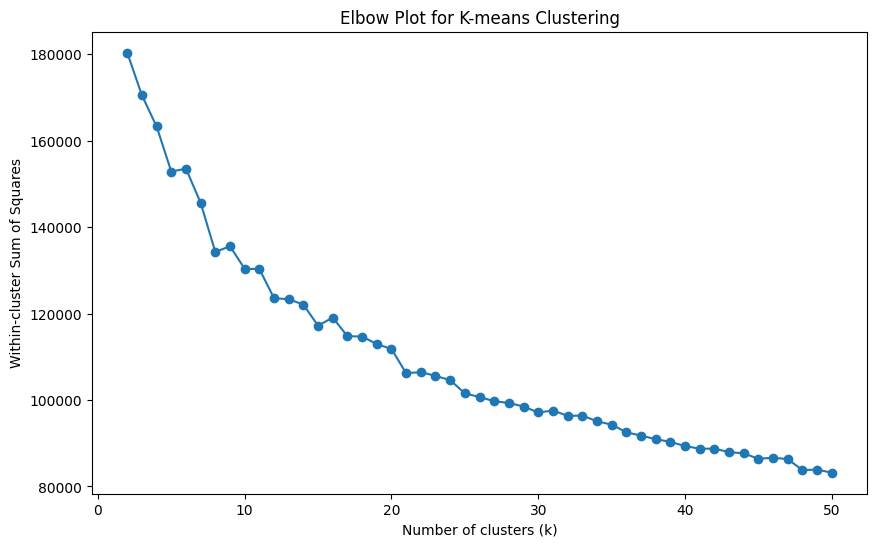

In [58]:
#FIRST, we need to find a good value for k (number of clusters).
#We will do this by plotting the within-cluster sum of squares (WSS) for different values of k
#and looking for an 'elbow' in the plot where the WSS starts to decrease more slowly.

#initialize a vectorizer:
vectorizer = CountVectorizer()

#transform texts into a document-term matrix:
features = vectorizer.fit_transform(texts)

#perform K-means clustering for different values of k
wss = []  #within-cluster sum of squares
max_k = 50  #maximum number of clusters to try

for k in range(2, max_k + 1):
    #print(f"Trying k={k}")
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
    km.fit(features)
    wss.append(km.inertia_)  # inertia_ gives the sum of squares within clusters

#create the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), wss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares')
plt.title('Elbow Plot for K-means Clustering')
plt.show()

In [61]:
# Import necessary libraries (assumed to be done earlier)
from sklearn.cluster import KMeans

# Set the number of clusters (k) based on the elbow plot analysis
k = 20  # Change this value according to your elbow plot results

# Perform K-means clustering with the chosen k
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Function to get the top words for each cluster
def get_top_words(center, feature_names, top_n=10):
    sorted_indices = center.argsort()[::-1]
    return [feature_names[i] for i in sorted_indices[:top_n]]

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Count documents in each cluster
cluster_sizes = [sum(cluster_labels == i) for i in range(k)]

# Print the number of documents in each cluster
print("Number of documents in each cluster:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i+1}: {size} documents")

#print a few example texts from each cluster
print("\nExample texts from each cluster:")
for i in range(k):
    cluster_texts = [text for text, label in zip(texts, cluster_labels) if label == i]
    print(f"\nCluster {i+1}:")
    for text in cluster_texts[:3]:  # Print first 3 texts in the cluster
        print(f"- {text[:50]}...")  # Print first 50 characters of each text

Number of documents in each cluster:
Cluster 1: 955 documents
Cluster 2: 1 documents
Cluster 3: 1 documents
Cluster 4: 23 documents
Cluster 5: 1 documents
Cluster 6: 1 documents
Cluster 7: 1 documents
Cluster 8: 1 documents
Cluster 9: 1 documents
Cluster 10: 1 documents
Cluster 11: 1 documents
Cluster 12: 1 documents
Cluster 13: 1 documents
Cluster 14: 5 documents
Cluster 15: 1 documents
Cluster 16: 1 documents
Cluster 17: 1 documents
Cluster 18: 1 documents
Cluster 19: 1 documents
Cluster 20: 1 documents

Example texts from each cluster:

Cluster 1:
- graeme yes known bresenhams run length slice algor...
- friend mine eight mb n simms sale best offer since...
- sell mine obo never used decided nt time get c...

Cluster 2:
- archivename jpegfaq lastmodified may faq article d...

Cluster 3:
- invitation th scia th scandinavian conference imag...

Cluster 4:
- rena q morrowstanfordedu salem pangeastanfordedu b...
- one candidate suggested key registration body aclu...
- earlier article e

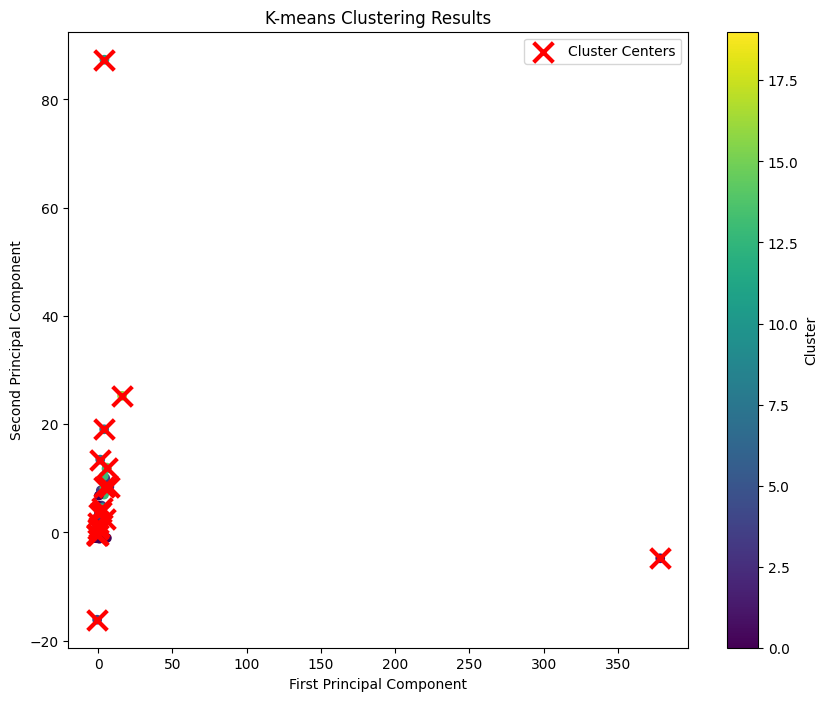

In [62]:
# Call the function to visualize clusters
visualize_clusters(features, cluster_labels, k)